In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import sleep

import numpy as np
from numpy.random import uniform, seed
import pandas as pd

from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython import display
sns.set_style('white')
seed(42)
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))

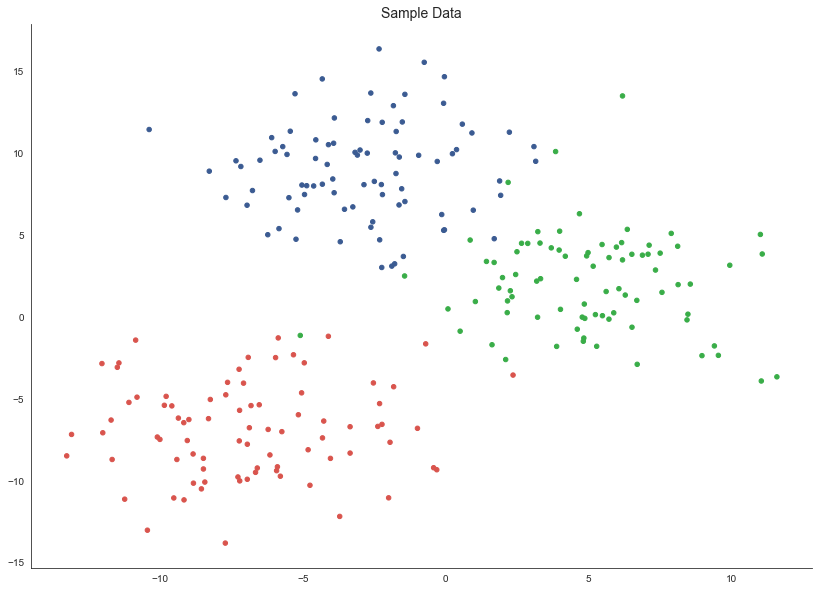

In [2]:
# 2D Cluster Demo
def sample_clusters(n_points=500, n_dimensions=2, n_clusters=5, cluster_std=1):
    # Generate isotropic Gaussian blobs for clustering
    return make_blobs(n_samples=n_points, n_features=n_dimensions, centers=n_clusters, cluster_std=cluster_std,
                      random_state=42)

data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=3, cluster_std=3)
x, y = data.T

plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=labels, s=20, cmap=cmap)
plt.title('Sample Data', fontsize=14)
sns.despine();

In [3]:
# K-Means Implementation
def assign_points(centroids, data):
    # pdist   -- pairwise distances between observation vectors.
    # cdist   -- distances between two collections of observation vectors
    dist = cdist(data, centroids)
    assignments = np.argmin(dist, axis=1)   # centroid with min distance
    return assignments

def optimize_centroids(data, assignments):
    data_combined = np.column_stack((assignments.reshape(-1, 1), data))
    centroids = pd.DataFrame(data=data_combined).groupby(0).mean()
    return centroids.values

# Measure Distance from Points to Centroids
def distance_to_center(centroids, data, assignments):
    distance = 0
    for c, centroid in enumerate(centroids):
        assigned_points = data[assignments == c, :]
        distance += np.sum(cdist(assigned_points, centroid.reshape(-1, 2)))
    return distance

# Plot Clusters Dynamically
def plot_clusters(x, y, labels, centroids, assignments, distance, iteration, step, ax, delay=2):
    ax.clear()
    ax.scatter(x, y, c=labels, s=20, cmap=cmap)
    # plot cluster centers
    centroid_x, centroid_y = centroids.T
    ax.scatter(*centroids.T, marker='o', c='w', s=200, cmap=cmap, edgecolor='k', zorder=9)
    for label, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker=f'${label}$', s=50, edgecolor='k', zorder=10)
    # plot links to cluster centers
    for i, label in enumerate(assignments):
        ax.plot([x[i], centroid_x[label]], [y[i], centroid_y[label]], ls='--', color='black', lw=0.5)
    sns.despine()
    title = f'Iteration: {iteration} | {step} | Inertia: {distance:,.2f}'
    ax.set_title(title, fontsize=14)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

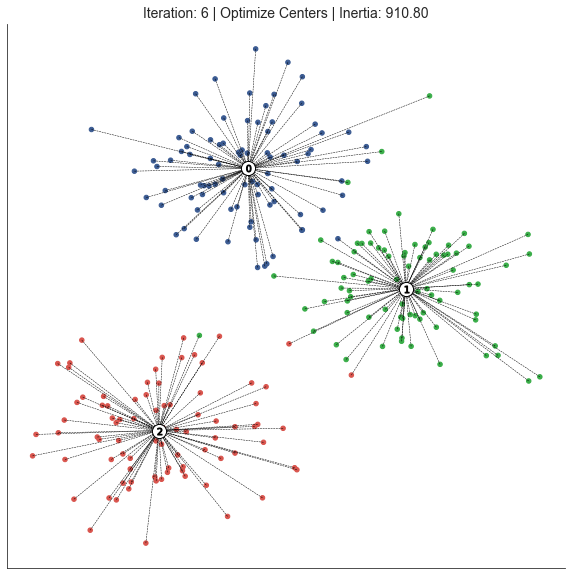

In [4]:
# Run K-Means Experiment
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=n_clusters, cluster_std=3)
x, y = data.T
x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))
distance = np.sum(np.min(cdist(data, centroids), axis=1))
fig, ax = plt.subplots(figsize=(10, 10))

iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_clusters(x, y, labels, centroids, assignments, distance, iteration, step='Assign Points', ax=ax)

    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta

    plot_clusters(x, y, labels, centroids, assignments, distance, iteration, step='Optimize Centers', ax=ax)

    iteration += 1

In [5]:
# Plot Voronoi Tesselation
def plot_voronoi(x, y, labels, centroids, assignments, distance, iteration, step, ax, delay=1):
    ax.clear()
    ax.scatter(x, y, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T, marker='o', c='w', s=200, edgecolor='k', zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker=f'${i}$', s=50, edgecolor='k', zorder=10)

    # plot links to centroid
    cx, cy = centroids.T
    for i, label in enumerate(assignments):
        ax.plot([x[i], cx[label]],  [y[i], cy[label]], ls='--', color='k', lw=0.5)

    # plot voronoi
    xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01),
                         np.arange(y.min() - 1, y.max() + 1, .01))
    Z = assign_points(centroids,  np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.imshow(Z, interpolation='nearest',  extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap,
               aspect='auto',  origin='lower', alpha=.2)
    title = f'Iteration: {iteration} | {step} | Distance: {distance:,.1f}'
    ax.set_title(title)
    sns.despine()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

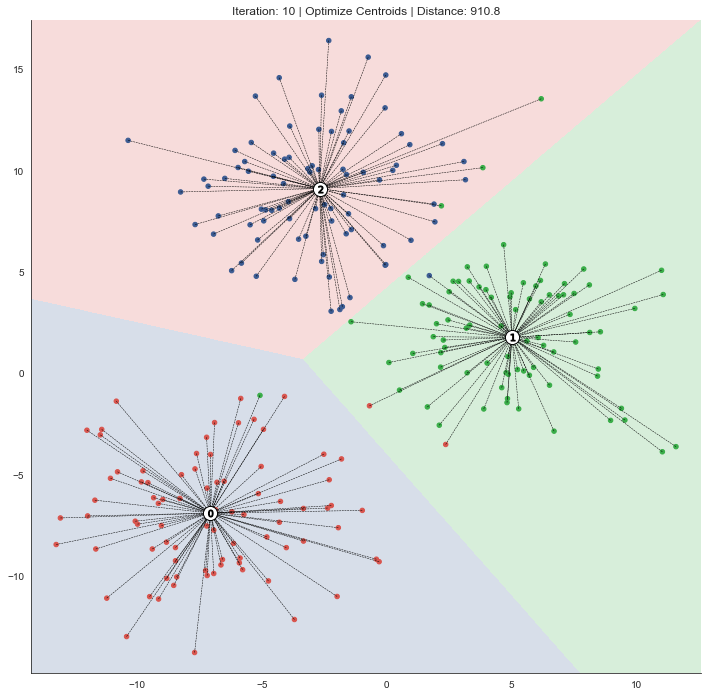

In [6]:
# Run Voronoi Experiment
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=n_clusters, cluster_std=3)
x, y = data.T
x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))

distance = np.sum(np.min(cdist(data, centroids), axis=1))
fig, ax = plt.subplots(figsize=(12, 12))

iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_voronoi(x, y, labels, centroids, assignments, distance, iteration, step='Assign Data', ax=ax)

    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta

    plot_voronoi(x, y, labels, centroids, assignments, distance, iteration, step='Optimize Centroids', ax=ax)
    iteration += 1